# _**DBSCAN**_   

__<u>DBSCAN</u>__ (Density-Based Spatial Clustering of Applications with Noise) (пространственная кластеризация приложений на основе плотности с шумом).   
- число кластеров	- определяется автоматически  
- форма кластеров	- любая, в т.ч несимметричная  
- Обнаружение выбросов - может оставлять    
- производительность - медленнее, но качественнее (?)  
- чувствительность к параметрам - зависит от eps и min_samples   
- применение - Хорош для плотностных кластеров и выбросов  

Это работает так: сначала мы выбираем два параметра, положительное число epsilon и натуральное число minPoints. Затем мы начинаем с выбора произвольной точки в нашем наборе данных. Если в пределах расстояния epsilon от этой точки находится более minPoints точек (включая саму исходную точку), мы считаем, что все они являются частью «кластера». Затем мы расширяем этот кластер, проверяя все новые точки и выясняя, есть ли у них также более minPoints точек в пределах расстояния epsilon, рекурсивно увеличивая кластер, если это так.  

В конце концов, у нас заканчиваются точки для добавления в кластер. Затем мы выбираем новую произвольную точку и повторяем процесс. Теперь вполне возможно, что выбранная нами точка имеет меньше minPoints точек в своем эпсилон-шаре, а также не является частью какого-либо другого кластера. Если это так, то она считается «шумовой точкой», не принадлежащей ни одному кластеру.  
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

# <font color='yellow'>->_pip, import_

#### <font color='yellow'>_Импорты_

In [ ]:
!pip install transformers[sentencepiece]
!pip install -U sentence-transformers
!pip install huggingface_hub
!pip install tqdm
!pip install umap-learn

In [2]:
import torch
from sentence_transformers import SentenceTransformer

In [3]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Кластеризатор
from sklearn.cluster import DBSCAN

#### <font color='yellow'>_Работа локально_

In [ ]:
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv

# Проверка
load_dotenv()
print(os.getenv("HF_TOKEN"))

# Использования токена:
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

In [ ]:
sys.path.append('./Classifiers')
import classifiers_functions

#### <font color='yellow'>_Работа на Google Colab_

In [4]:
# передача токена в HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [5]:
# Связь с Google drıve (для связи с файлами данных на google drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='yellow'>_-> эмбеддинг данных</small>_ </font>  

### _собственно эмбеддинг_

In [ ]:
# === Загрузка модели (перевод на CUDA, если возможно) ===

model_name = "cointegrated/rubert-tiny2"  # Можно RuBERT
# model_name = "sentence-transformers/LaBSE"  # Можно RuBERT
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_name).to(device)

In [ ]:
# === Параметры для загрузки текста ===

chunk_size = 1000
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'

In [ ]:
# Читаем первый chunk и смотрим полученные данные
chunk = next(pd.read_csv(file_path_data, chunksize=chunk_size))  # Загружаем первый кусок
print(chunk.head())  # Вывод первых строк
print(chunk.columns)  # Вывод всех колонок в файле

In [ ]:
# Видим, что текст  в колонке `title`, добавляем параметр
text_column = "title"  # Название колонки с текстами

In [ ]:
# Выполняем одновременно:
# - чтение текстов из файла (до заданного к-ва)
# - их эмбеддинг

all_texts = []
embeddings_list = []
all_clusters = []  # Сюда будем добавлять номера кластеров

max_text = 5000 # maximum number of texts
current_count = 0

# Загружаем данные по частям (количеством текстов = max_text) и выполняем эмбеддинг

# ____________ tqdm — это Python-библиотека, которая добавляет прогресс-бар при выполнении цикла. Название происходит от арабского "taqaddum" — «прогресс».
# ____________ показывает: текущий прогресс (в процентах), количество итераций, время выполнения, ETA (оценку оставшегося времени), скорость обработки.

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):

    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]

    embeddings_chunk = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # Эмбеддинг текстов

    # Добавляем эмбеддинги и тексты в общий список
    all_texts.extend(texts) # Сохраняем тексты
    embeddings_list.append(embeddings_chunk)

    current_count += len(texts)
    if current_count >= max_text:
        break

# === Объединяем все эмбеддинги ===
embeddings = np.vstack(embeddings_list)  # Превращаем список батчей в одну матрицу


### _проверка на нормализованность_

По умолчанию,  
в _embeddings = model.encode(texts)_  
стоит ", normalize_embeddings=True", который отвечает за L2-нормализацию выходных векторов:
$$ norm(x) = \sqrt{x_{1}^2 + x_{2}^2 + ...+ x_{n}^2} = 1 $$  
т.е. у нас каждый вектор должен иметь единичную длину  
<small>Кстати. При классификации эмбеддингов, в которых схожесть объектов определяется косинусным расстоянием, в классификаторах лучше использовать косинусную метрику вместо евклидовой. Но, если эмбеддинги уже нормализованы (единичная длина), то минимизация евклидового расстояния эквивалентна минимизации косинусного расстояния, так как:  
$$
\text{cosine distance} = 1 - \cos(\theta) = 1 - \frac{A \cdot B}{\|A\| \|B\|}
$$  
При ∥𝐴∥ = ∥𝐵∥ = 1 , минимизация евклидова расстояния  ∥A−B∥ будет приводить к той же кластеризации, что и минимизация косинусного расстояния.<small>

In [ ]:
# Проверка
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

In [ ]:
# Если нет, можно их нормализовать вручную
from sklearn.preprocessing import normalize
normalized_embeddings = normalize(embeddings, norm="l2")

### _сохранение эмбеддингов_

In [ ]:
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу для сохранения эмбеддингов
np.save(file_path_embeddings, embeddings)  # Сохраняем эмбеддинги в файл
print(f"✅ Обработано {len(embeddings)} текстов. Эмбеддинги сохранены в {file_path_embeddings}")

✅ Обработано 27000 текстов. Эмбеддинги сохранены в /content/drive/My Drive/Example_ML/Data/embeddings_rubert-tiny2.npy


In [ ]:
print(type(embeddings))
print(embeddings.shape)

# <font color='lightblue'>-> _кластеризация по сохраненным эмбеддингам_

### _загрузка текстов и их эмбеддингов <font color='orange'><small>(all_texts, ebeddings)_  

In [ ]:
# Если не было ранее подключение в google drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Загрузка текстов

# _______ Параметры ______________
chunk_size = 1000 # # Размер чанка при загрузке текстов
# Google Colab
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'
# Локально
# file_path_data = 'articles.csv'
text_column = "title"  # Название колонки с текстами

# _________ Загрузка _______________________

all_texts = []
max_text = 5000 # maximum number of texts !!! Используется в названии файла !!!
current_count = 0

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):
    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]
    all_texts.extend(texts)  # Объединяем части текста вместе

    current_count += len(texts)
    if current_count >= max_text:
        break

len(all_texts) # list

Обработка данных: 4it [00:00, 16.27it/s]


5000

In [7]:
# Загрузка эмбеддингов

# _________ Параметры ____________
batch_size = 1000  # Размер батча

# Google Colab
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу эмбеддингов
# Локально
# file_path_embeddings = './Data/embeddings_rubert-tiny2.npy'  # Файл с эмбеддингами

# _________ Загрузка _______________________
# Загружаем файл в режиме "чтение без загрузки в память"
embeddings_mmap = np.load(file_path_embeddings, mmap_mode="r")

num_samples = embeddings_mmap.shape[0] # Определяем количество примеров (должно быть = max_text)
all_embeddings = [] # Пустой список для хранения частей эмбеддингов

# Читаем файл частями
for i in range(0, num_samples, batch_size):
    batch = embeddings_mmap[i : i + batch_size]  # Загружаем батч
    all_embeddings.append(batch)  # Добавляем в список

embeddings = np.vstack(all_embeddings) # Объединяем все части в один массив NumPy

print(f"Форма объединённого массива: {embeddings.shape}") # Проверяем размер итогового массива

Форма объединённого массива: (5000, 312)


### _анализ данных_ <font color='orange'><small>(дендрограмма, среднее расстояние между точками, проверка эмбеддингов (нормализация)</small>).

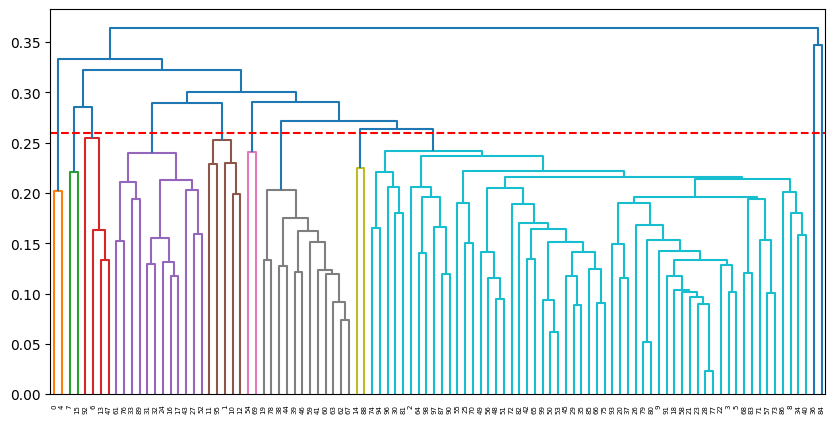

In [8]:
# _________Построением дендрограммы_________
# 📌 Позволяет прикинуть, на сколько классов целесообразно разбить данные.
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(embeddings[:100], method='average', metric='cosine'))

# Добавляем горизонтальную линию на уровне ...
plt.axhline(y=0.26, color='r', linestyle='--')  # Порог для разбиения

plt.show()

In [9]:
# _________Среднее расстояние между точками.___________
# 📌 Для DBSCAN это дает ориентир для выбора значения `eps` - параметра окна, в котором подсчитывается число "соседних" точек.
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5) #  ищем 5 ближайших соседей для каждой точки.
neighbors.fit(embeddings)                   #  "запоминаем" точки эмбеддингов в алгоритме ближайших соседей.
#  вычисляем расстояния до n_neighbors ближайших точек.
distances, _ = neighbors.kneighbors(embeddings)
avg_distance = np.mean(distances[:, -1])  # Среднее расстояние до 5-го соседа
print(f"Среднее расстояние между точками: {avg_distance:.4f}")
# Среднее расстояние между точками: 0.4798

Среднее расстояние между точками: 0.5162


<small>Что делает `distances, _ = neighbors.kneighbors(embeddings)`  
В distances[i, j] хранится расстояние от i-го эмбеддинга текста до его j-го ближайшего соседа. Пример: distances[:]  
```
array([
    [0.00, 0.32, 0.45, 0.51, 0.67],  # 5 соседей для 1-го эмбеддинга текста
    [0.00, 0.28, 0.41, 0.55, 0.70],  # 5 соседей для 2-го эмбеддингатекста
    ...
    [0.00, 0.30, 0.49, 0.60, 0.80]   # 5 соседей для 27000-го эмбеддинга текста
])
```
distances[i, -1] — расстояние до самого дальнего из 5 соседей.</small>

In [10]:
# Нормализация эмбеддингов (проверка)
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

Min norm: 0.9999998807907104
Max norm: 1.0000001192092896
Mean norm: 1.0


### _кластеризация_

In [12]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  This implementation has a worst case memory complexity of :math:`O({n}^2)`,
 |  which can occur when the `eps` param is large and `min_samples` is low,
 |  while the original DBSCAN only uses linear memory.
 |  For further details, see the Notes below.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, default=0.5
 |      The maximum distance between two samples for one to be considered
 |   

In [ ]:
# Количественное распределение текстов по кластерам:
from collections import Counter

In [98]:
# Задаем параметры
eps_values = 0.156
min_samples = 3
# Выполняем кластеризацию
dbscan = DBSCAN(eps=eps_values, min_samples=min_samples, metric="cosine")
clusters = dbscan.fit_predict(embeddings)
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"eps={eps_values}, min_samples={min_samples} → найдено кластеров: {num_clusters}, шумовых точек: {np.sum(clusters == -1)}")
counts_cluster = Counter(clusters) # Количественное распределение текстов по кластерам:
counts_cluster

eps=0.156, min_samples=3 → найдено кластеров: 7, шумовых точек: 546


Counter({np.int64(0): 4434,
         np.int64(-1): 546,
         np.int64(1): 3,
         np.int64(2): 5,
         np.int64(3): 3,
         np.int64(4): 3,
         np.int64(5): 3,
         np.int64(6): 3})

In [ ]:
# Формируем датафрейм их текстов, их эмбеддингов и меток
df = pd.DataFrame({"text": all_texts, "embedding": list(embeddings), "cluster": list(clusters)})
df.head()

In [67]:
# Просмотр релевантности текстов в кластерах определенным темам
claster_number = 17 # Выбор номера кластера
df_filtered =  df[df["cluster"] == claster_number] # Фильтруем строки
print(df_filtered['text'].tail(10)) # Выводим первые 10 строк

3072    США депортировали в Канаду самого молодого зак...
3088    Рядовой армии США Брэдли Мэннинг, обвиняемый в...
4054    Канадский офицер ВМС, обвиняемый вnшпионаже в ...
4584    Военный суд в США отложил слушания по делу сол...
Name: text, dtype: object


In [66]:
# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_DBSCAN_{max_text}.csv'
# Локально
# output_file = f"./Data/clusters_rubert-tiny2_KMeans_{max_text}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_DBSCAN_5000.csv.


## <font color='lightgreen'>_-> Визуализация кластеров_</font>

In [69]:
# Признаки (эмбеддинги)
X_old = np.stack(df['embedding'].to_numpy()) # Преобразуем списка с эмбеддингами в массив чисел
# Метки
y_old = df['cluster']

print(X_old.shape, X_old.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_old.shape, y_old.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float32
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


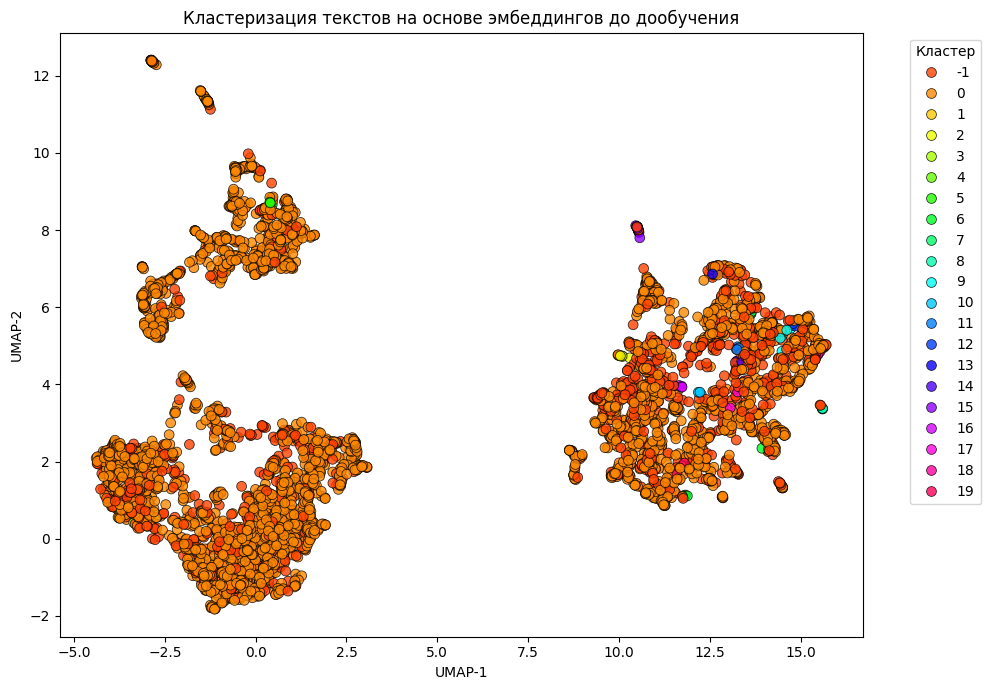

In [70]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_old)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_old
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_old)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов до дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Все плохо ...